In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

### Image Pre-processing

The VGG-16 model requires a 224x224 sized image with 3 channels (RGB) as input.

In [ ]:

transform = v2.Compose([
    v2.Resize((224, 224)),  # Resizing to 224x224
    v2.ToTensor(),  # Converting to tensor
    v2.Normalize(   # Normalize using the mean and std given in the vgg16 pytorch documentation
        mean=[0.48235, 0.45882, 0.40784], 
        std=[0.00392156862745098, 0.00392156862745098, 0.00392156862745098]
    )
])

train_dataset = ImageFolder("data/cats-vs-dogs/train", transform=transform)
test_dataset = ImageFolder("data/cats-vs-dogs/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


/home/carlos/fine-tuning-vision-model/.venv/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


torch.Size([32, 3, 224, 224])
tensor([1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 1, 1, 0, 0])


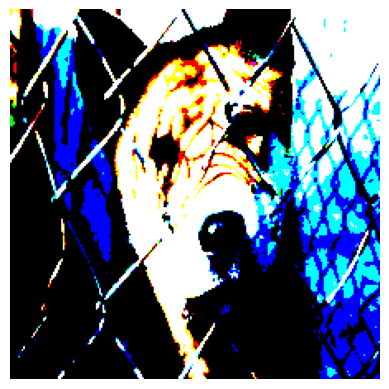

In [ ]:
# Function to display an image
def imshow(tensor):
    image = tensor.numpy().transpose((1, 2, 0))  # Change from [C, H, W] to [H, W, C]
    image = np.clip(image, 0, 1)  # Clamp values to [0, 1] for display
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Show an image, its shape and labels
for images, labels in train_loader:
    print(images.shape)
    print(labels)
    imshow(images[0])
    break

### Loading Pre-trained Model

We will load the model with the pre-trained weights. Then we want to freeze the convolutional layers of the model, so we only update the fully connected layers during the fine-tuning.

In [32]:
from torchvision.models import vgg16, VGG16_Weights
import torch.nn as nn

In [ ]:
model = vgg16(weights=VGG16_Weights.DEFAULT)    # Load pre-trained model with weights


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/carlos/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [01:33<00:00, 5.89MB/s] 


In [ ]:
# Examine the model
for layer in model.modules():
    print(layer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [34]:
# Freeze weights of the convolutional layers
for param in model.features.parameters():
    param.requires_grad = False

# Replace the classifier's last layer for binary classification
model.classifier[6] = nn.Linear(4096, 2)

# Move to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)